In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2.1 Loading and Cleaning Data**

In [9]:
# file loading
location = "/content/drive/MyDrive/FML/Exercise4a/"
file = "CrowdstormingDataJuly1st.csv"

df = pd.read_csv(location + file)
pd.set_option('display.max_columns', None)

In [10]:
# dataframe which will be tranformed
dfT = df.copy()
display(dfT.head())

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,photoID,rater1,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,0,1,0,0,0,0,95212.jpg,0.25,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,0,1,0,1,0,0,1663.jpg,0.75,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,1,0,0,1,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,0,0,0,0,0,0,NaN,NaN,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


We first add a feature called 'refCount' (inspired by 'Crowdstorming_visulaization.ipynb')corresponding to the seniority of a referee. It is computed by the number of different dyads of a specific referee. We think it is an important feature as the experience level of a referee shoud correlate with the given number of red cards.

In [11]:
dfT['refCount'] = 0
refs = pd.unique(dfT['refNum'].values.ravel())

for r in refs:
  if (r % 1000) == 0:
    print('Ref number:', r)
  pd_indices = (dfT['refNum'] == r)
  newCount = len(dfT[pd_indices])
  dfT.loc[pd_indices, 'refCount'] = newCount

Ref number: 1000
Ref number: 2000
Ref number: 3000


Again inspired by 'Crowdstorming_visulaization.ipynb' we delete the dyads containing referees who appeared in less than 21 dyads as otherwise they did not even oversee a single game in one of the 4 leagues.

In [13]:
before = len(dfT)

dfT = dfT[dfT['refCount'] > 21]

after = len(dfT)
print('dayds deleted:', before - after)

dayds deleted: 0


This results in the deletion of 12527 dyads.

We then have a look at the skintone, which is rated by two different raters.

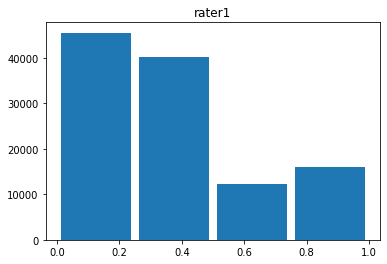

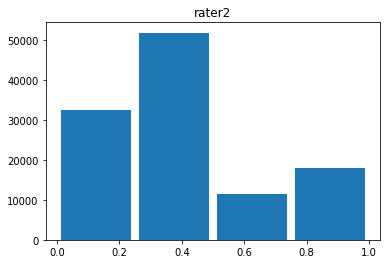

In [14]:
# skintone rates: 0, 0.25, 0.5, 0.75, 1.0
# rate < 0.5: light, rate > 0.5: dark, rate = 0.5: neither nor

plt.figure(0)
plt.title('rater1')
plt.hist(dfT['rater1'], bins=[0.0, 0.25, 0.5, 0.75, 1.0], rwidth=0.9)
plt.show()

plt.figure(0)
plt.title('rater2')
plt.hist(dfT['rater2'], bins=[0.0, 0.25, 0.5, 0.75, 1.0], rwidth=0.9)
plt.show()

So there appear to be cases where both raters do not agree.

In [15]:
# Calculating percentage of dyads where raters do not agree:
temp = dfT['rater1'] == dfT['rater2']

print('Percentage of dyads where do not agree:', 100 * (1- np.sum(temp)/ len(temp)))

Percentage of dyads where do not agree: 34.499367045939735


We then also decide to take the mean rate as a new skintone feature:

In [16]:
# The skintone feature is added consisting of the mean of the two rates
dfT['skintone'] = (dfT['rater1'] + dfT['rater2']) / 2

We consider the features 'leagueCountry' and 'position' to be important and therefore one-hot encode them. We also thought about one-encoding 'refCountry' but decided against it as there are too many countries and the one-hot encoding would explode the feature space.

In [17]:
def one_hot(df, feature):
  """
  Returns the df with added one-hot encoded columns of
  the given feature, the original feature column is dropped
  """
  df_onehot = pd.get_dummies(df[feature])
  df = df.join(df_onehot)
  df.drop(feature, 1, inplace=True)

  return(df)

dfT = one_hot(dfT, 'leagueCountry')
dfT = one_hot(dfT, 'position')

In the following we then drop all rows that contain any NaN values. We decided against exploring other possible ways to deal with missing values (e.g imputation as explained in wikipedia article). This is mainly due to the fact that we think that we have enough instances available in our data and the deletion of NaN rows only leads to a reduction of N=133501 to N=113127.

In [19]:
# We then drop all rows that contain any NaN values 

before = len(dfT)

dfT.dropna(axis=0, inplace=True)

after = len(dfT)

print('dyads before:', before)
print('dyads after:', after)
print('dyads deleted:', before - after)
# resulting in the deletion of 20374 dyads

dyads before: 113127
dyads after: 113127
dyads deleted: 0


We also consider the feature 'age' an important feature as old players and therefore more experienced ones might have a lower tendency to receive red cards.

In [20]:
# Introducing an age feature

birthday = np.array(dfT['birthday'])
age = np.zeros(len(birthday))

for i in range(len(birthday)):
  age[i] = 2012 - float(birthday[i][6:])

dfT['age'] = age

Finally, we normalize+centralize or just centralize the following features. Features with values between 0 and 1 are centralized and features with values outside that range are normalized+centralized.

In [21]:
# The following features are then normalized+centralized or just centralized:
# 'height', 'weight', 'victories', 'refCount', 'age', 'meanIAT', 'meanExp'
# and 'skintone'

def centralize(df, feature):
  '''
  Centralizes given feature 
  '''
  mean_feat = np.mean(df[feature])
  new_vals = df[feature] - mean_feat
  df[feature] = new_vals

  return(df)


def normANDcentr(df, feature):
  """
  Centralizes given feature and scales with 1/std
  """
  min_feat = np.min(df[feature])
  max_feat = np.max(df[feature])
  new_vals_temp = (df[feature] - min_feat) / (max_feat - min_feat)
  mean_new_vals_temp = np.mean(new_vals_temp)
  df[feature] = new_vals_temp - mean_new_vals_temp

  return(df)

# Creating dataframe of nontransformed columns, needed for later analysis
# of direction of bias (2.3 - 2.5)
list_copy = ['height', 'weight', 'victories', 'ties', 'defeats', 'age',
             'refCount', 'meanExp', 'skintone']
dfnonT = dfT[list_copy].copy()


dfT = normANDcentr(dfT, 'height')
dfT = normANDcentr(dfT, 'weight')
dfT = normANDcentr(dfT, 'victories')
dfT = normANDcentr(dfT, 'ties')
dfT = normANDcentr(dfT, 'defeats')
dfT = normANDcentr(dfT, 'age')
dfT = normANDcentr(dfT, 'refCount')

dfT = centralize(dfT, 'meanIAT')
dfT = centralize(dfT, 'meanExp')
dfT = centralize(dfT, 'skintone')


In [22]:
# introducing dataframe for target values
dfY = dfT['redCards'] / dfT['games']

Then we drop the following columns due to obvious reasons (Not a feature, already transformed column,...):

In [23]:
columns_drop = ['playerShort' , 'player', 'birthday', 'games', 'yellowReds', 'refCountry', 'redCards', 'photoID', 'rater1', 'rater2']

for column in columns_drop:
  dfT.drop(column, 1, inplace=True)

Furthermore, we drop the following feature columns, as we do not consider them important here:

In [24]:
features_drop = ['club', 'goals', 'yellowCards', 'refNum', 'Alpha_3', 'nIAT', 'seIAT', 'nExp', 'seExp']
#features_drop = ['club', 'goals', 'yellowCards', 'refNum', 'Alpha_3', 'nIAT', 'seIAT', 'nExp', 'seExp', 'position']

for feature in features_drop:
  dfT.drop(feature, 1, inplace=True)

# printing the final dataframe we will use in the following
display(dfT.head())

,height,weight,victories,ties,defeats,meanIAT,meanExp,refCount,skintone,England,France,Germany,Spain,Attacking Midfielder,Center Back,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger,age
5,-0.002287,-0.115533,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.244809
6,0.116761,0.080120,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.005191
7,-0.049906,-0.180750,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,0.717333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.046858
8,0.259618,0.080120,-0.048276,0.017770,-0.054778,-0.023132,0.075924,-0.336462,-0.032667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.036476
9,-0.049906,-0.137272,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.282667,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.088524


## **2.2 Model Creation**

## i) Linear Regression:

In [25]:
# preparing data to perform linear regression
# working with numpy arrays
X = dfT.to_numpy()

# target values
Y = dfY.to_numpy()

# transform to column vector
Y = Y[:, np.newaxis]

#print('X.shape:', X.shape)
#print('Y.shape:', Y.shape)

First we use the whole dataset as training data and calculate the squared training error. In the following we always use the numpy built in np.linalg.pinv() function to calculate the pseudo inverse of the matrix X, which uses the SVD decomposition.

In [26]:
# Using whole dataset for training

# Pseudo inverse using the SVD decomposition
Xplus = np.linalg.pinv(X)

beta = Xplus @ Y
Y_pred = X @ beta

#print('Xplus.shape:', Xplus.shape)
#print('beta.shape:', beta.shape)
#print('Y_pred.shape:', Y_pred.shape)

error_train = 1 / len(Y_pred) * np.sum((Y - Y_pred)**2)
print('training error:', error_train)

training error: 0.0026041168700503626


To calculate the test error, we then perform 10fold cross validation:

In [27]:
from sklearn.model_selection import KFold

In [28]:
# Squared test error with 10 fold cross validation

def cross_val(Nfolds, X, Y, beta):
  '''
  Returns the Nfolds fold mean cross validation error
  '''
  k_folds = KFold(n_splits=Nfolds)

  err_arr = np.zeros(Nfolds)

  # cross validation loop
  for i, (train_index, test_index) in enumerate(k_folds.split(X)):
    Xplus = np.linalg.pinv(X[train_index, :])
    beta = Xplus @ Y[train_index, :]

    Y_truth = Y[test_index, :]
    Y_pred = X[test_index, :] @ beta
    
    error_test = 1 / len(Y_pred) * np.sum((Y_truth - Y_pred)**2)
    err_arr[i] = error_test

  err_mean = np.mean(err_arr)
  
  return(err_mean)

err_test_cross = cross_val(10, X, Y, beta)

print('Cross validation test error:', err_test_cross)

Cross validation test error: 0.0026053871139780477


## ii) Regression Forest:

In [29]:
class Node:
    pass

class Tree:
    def __init__(self):
        self.root = Node()
    
    def find_leaf(self, x):
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node


In [30]:
class RegressionTree(Tree):
    def __init__(self):
        super(RegressionTree, self).__init__()
        
    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D)) # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels
        
        #put root in stack
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0] # number of instances in present node
            if n >= n_min:
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                
                perm = np.random.permutation(D)   # permute D indices
                left, right = make_decision_split_node(node, perm[:D_try]) #select :D_try of permuted indices
                                                       #for 'make_decision_split_node()'
                # put children in stack
                stack.extend([left, right])
                
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node)
                
    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return leaf.response 

In [33]:
def rss(y_left, y_right):
    """
    function to calculate residual square 
    """
    def ssr(y):
      '''
      Function to calculate the sums
      '''
      return np.sum((y - np.mean(y)) ** 2)
    
    return ssr(y_left) + ssr(y_right)

def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = 1e100
    j_min, t_min = 0, 0
    for j in feature_indices:
        # remove duplicate features
        dj = np.sort(np.unique(node.data[:,j]))
        # compute candidate thresholds in the middle between consecutive feature values
        tj = 0.5 * (dj[1:] + dj[:-1]) 
        # each candidate threshold we need to compute the residual square error
        for t in tj:
            left_indices = node.data[:,j] <= t
            ll = node.labels[left_indices]
            lr = node.labels[node.data[:,j] > t]
            t_rss = rss(ll, lr)
            # choose the the best threshold that minimizes the rss
            if t_rss < e_min:
                e_min = t_rss
                j_min = j
                t_min = t


    # create children
    left = Node()
    right = Node()
    
    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    left.data = node.data[node.data[:,j_min] <= t_min, :]
    left.labels = node.labels[node.data[:,j_min] <= t_min]
    right.data = node.data[node.data[:,j_min] > t_min, :]
    right.labels = node.labels[node.data[:,j_min] > t_min]

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min
    node.data = None #releasing memory
    
    # return the children (to be placed on the stack)
    return left, right    

In [34]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    ##using the definition of the average label as the response
    node.N = node.labels.shape[0]
    node.response = np.mean(node.labels) / node.N

Defining forests:

In [35]:
class RegressionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [RegressionTree() for i in range(n_trees)]
    
    def train(self, data, labels, n_min=0):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data
            bootstrap = np.random.choice(len(data), size=len(data))
            tree.train(data[bootstrap], labels[bootstrap], n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return np.mean([tree.predict(x) for tree in self.trees], axis=0)

Evaluating the Results through cross validation

In [36]:
#using n_min=100 for a start
n_min=100
#initialising regression forest
rf = RegressionForest(20)
rf.train(X, Y, n_min)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: ignored

The training sadly runs into runtime issues, we couldn't complete the rest in time. This might be because the regression forest does not work correctly.

## **2.3 Anwering the Research Question**

In [ ]:
# Performing Permutation test

def permutation_test(X_per, Y, beta, N_per, feat_column, err_normal):
  '''
  Performs permutation test: compares scattered errors (err_per_arr) 
  with the given unscattered error (err_normal) and determines if all
  scattered errors are larger
  Returns the scattered error array (err_per_arr)
  '''
  # array holding the 19 errors, each obtained with 10 fold cross validation

  err_per_arr = np.zeros(N_per)

  # permutation loop
  for m in range(N_per):
    if (m % 5 == 0):
      print('Permutation:', m)

    # shuffling information of feat_column
    np.random.shuffle(X_per[:, feat_column])

    # 10 fold cross-validation
    err_cross = cross_val(10, X_per, Y, beta)
    err_per_arr[m] = err_cross
  
  # evaluate if scattered errors are larger
  temp_arr = (err_per_arr > err_normal)
  print('temp_arr: \n', temp_arr)
  print('All erros from permutation test are larger:', np.all(temp_arr))
  
  return(err_per_arr)
  
# creating copy of data 
X_per = np.copy(X)

# 9th column holds skintone information
err_per_arr = permutation_test(X_per, Y, beta, 19, 8, err_test_cross)

Permutation: 0
Permutation: 5
Permutation: 10
Permutation: 15
temp_arr: 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
All erros from permutation test are larger: True


Hence, there exists a significant skin color bias in red cards.

Determining direction of bias:

In [ ]:
# Direction of bias

# X[:, 8] + mean_skintone corresponds to backtransformation
# prediction for light and dark colored players
# getting non centralized values of skintone to find dark and light colored players

#indices_light = X[:, 8] + mean_skintone < 0.5
indices_light = np.array(dfnonT['skintone']) < 0.5
X_light = X[indices_light]
Y_light = Y[indices_light]

#indices_dark = X[:, 8] + mean_skintone > 0.5
indices_dark = np.array(dfnonT['skintone']) > 0.5
X_dark = X[indices_dark]
Y_dark = Y[indices_dark]


Y_pred_light = X_light @ beta
Y_pred_dark = X_dark @ beta

print('mean light colored prediction:', np.mean(Y_pred_light))
print('mean dark colored prediction:', np.mean(Y_pred_dark))

mean light colored prediction: 0.0040715653589513
mean dark colored prediction: 0.004869156330975599


Thus, there exists a bias towards the dark colored players.

## **2.4 How to lie with statistics**

In 2.3 we have seen a cleaned dataset which uncovers a skin color bias. So we now look for an equally plausible dataset, which does not uncover a skin color bias.

In [ ]:
display(dfT.head())

,height,weight,victories,ties,defeats,meanIAT,meanExp,refCount,skintone,England,France,Germany,Spain,Attacking Midfielder,Center Back,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger,age
5,-0.002287,-0.115533,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.244809
6,0.116761,0.080120,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.005191
7,-0.049906,-0.180750,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,0.717333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.046858
8,0.259618,0.080120,-0.048276,0.017770,-0.054778,-0.023132,0.075924,-0.336462,-0.032667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.036476
9,-0.049906,-0.137272,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.282667,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.088524


One could argue that for example the feature: 'position' could be dropped from the dataset. One could say that commiting a red card foul or action is quite an extreme case. It therefore should not depend on the player's position as any position is equally likely to be drawn into such an extreme foul or action.

In [ ]:
# Building new dataset without 'position' feature
dfnew = dfT.iloc[:, 0:13]
dfnew['age'] = dfT['age']
display(dfnew.head())

,height,weight,victories,ties,defeats,meanIAT,meanExp,refCount,skintone,England,France,Germany,Spain,age
5,-0.002287,-0.115533,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0.244809
6,0.116761,0.080120,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,-0.005191
7,-0.049906,-0.180750,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,0.717333,1,0,0,0,-0.046858
8,0.259618,0.080120,-0.048276,0.017770,-0.054778,-0.023132,0.075924,-0.336462,-0.032667,1,0,0,0,0.036476
9,-0.049906,-0.137272,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.282667,0,0,1,0,-0.088524


With the new plausible dataset we perform linear regression , cross validation to get the test error and then a permutation test to see if a significant skin color bias exists:

In [ ]:
# regression
X_new = dfnew.to_numpy()

Xplus_new = np.linalg.pinv(X_new)

beta_new = Xplus_new @ Y

# test error 
err_test_cross_new = cross_val(10, X_new, Y, beta_new)

print('Cross validation test error of new dataset:', err_test_cross_new)

# permutation test

# creating copy of data
X_per_new = np.copy(X_new)

# 9th column holds skintone information
err_per_arrL = permutation_test(X_per_new, Y, beta_new,  19, 8, err_test_cross)

Cross validation test error of new dataset: 0.0026058398041508926
Permutation: 0
Permutation: 5
Permutation: 10
Permutation: 15
temp_arr: 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
All erros from permutation test are larger: True


As one can see the permuatation test still shows that there exists a significant skin color bias in red cards. So we did not succeed in finding a different plausible cleaned dataset that exhibits no skin color bias.

## **2.5 Alternative hypotheses**

In [ ]:
display(dfT.head())

,height,weight,victories,ties,defeats,meanIAT,meanExp,refCount,skintone,England,France,Germany,Spain,Attacking Midfielder,Center Back,Center Forward,Center Midfielder,Defensive Midfielder,Goalkeeper,Left Fullback,Left Midfielder,Left Winger,Right Fullback,Right Midfielder,Right Winger,age
5,-0.002287,-0.115533,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.244809
6,0.116761,0.080120,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.157667,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.005191
7,-0.049906,-0.180750,-0.048276,-0.053658,0.000777,-0.023132,0.075924,-0.336462,0.717333,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,-0.046858
8,0.259618,0.080120,-0.048276,0.017770,-0.054778,-0.023132,0.075924,-0.336462,-0.032667,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.036476
9,-0.049906,-0.137272,-0.013793,-0.053658,-0.054778,-0.023132,0.075924,-0.336462,-0.282667,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.088524


In order to answer this task we tried to think of plausible features in our dataset that might be correlated with the 'skintone' feature. The idea is that there might exist a spurious correlation between 'skintone' and 'redcards' which however is originally driven by the feature that is correlated with 'skincolor'.

1) So we thought of the hypothesis: 'referees discriminate against taller players'. Furthermore, we thought that there might be a positive correlation between 'skintone' and 'height' and hence referees would discrimitae against dark colored players.

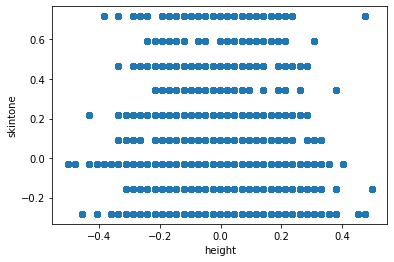

In [ ]:
height_arr = dfT['height']
skintone_arr = dfT['skintone']

plt.figure(0)
plt.scatter(height_arr, skintone_arr)
plt.xlabel('height')
plt.ylabel('skintone')
plt.show()

But already from eyeballing one can see, that hat our assumed correlation does not exist. Furthermore, we looked if there even exists a significant height bias:

In [ ]:
# permutation test

# creating copy of data
X_per = np.copy(X)

# 1st column holds height information
err_per_arr = permutation_test(X_per, Y, beta,  19, 0, err_test_cross)

Permutation: 0
Permutation: 5
Permutation: 10
Permutation: 15
temp_arr: 
 [False  True False False False  True False False False False False False
 False False  True False False False False]
All erros from permutation test are larger: False


As the permutation test shows, there does not even exist a significant height bias in red cards. So we can completeley discard our first hypothesis.

2) Secondly we came up with the hypothesis: 'referees discriminate against players from the english league compared to the german league'. This might be plausible as the english league is considered to be rougher. Furthermore, we thought that there might be a positive correlation between 'skintone' and the both leagues and hence referees would discriminate against dark colored players.

mean skintone england: 0.031865835522882024
mean skintone germany: -0.07887978416530667


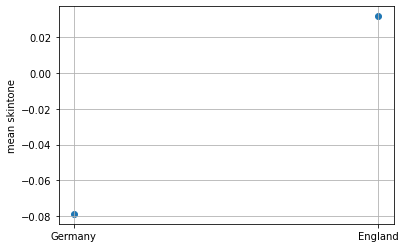

In [ ]:
# mean skintone in both leagues
df_england = dfT[dfT['England'] == 1]
df_germany = dfT[dfT['Germany'] == 1]

mean_tone_england = np.mean(df_england['skintone'])
mean_tone_germany = np.mean(df_germany['skintone'])
print('mean skintone england:', mean_tone_england)
print('mean skintone germany:', mean_tone_germany)

x = [0, 1]
plt.figure(0)
plt.scatter(x, [mean_tone_germany, mean_tone_england])
my_xticks = ['Germany','England']
plt.xticks(x, my_xticks)
plt.grid()
plt.ylabel('mean skintone')
plt.show()

So we have found the correlation between the 'skintone' and the both leagues.

We then perform two permutation tests in order to see if there exist significant league biases both for England and Germany.

In [ ]:
# english league
X_per = np.copy(X)

# 10th column for english league
err_per_arr = permutation_test(X_per, Y, beta, 19, 9, err_test_cross)

# german league
X_per = np.copy(X)

# 12th column for german league
err_per_arr = permutation_test(X_per, Y, beta, 19, 11, err_test_cross)

Permutation: 0
Permutation: 5
Permutation: 10
Permutation: 15
temp_arr: 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
All erros from permutation test are larger: True
Permutation: 0
Permutation: 5
Permutation: 10
Permutation: 15
temp_arr: 
 [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
All erros from permutation test are larger: True


Hence, for both leagues there exists a significant league bias in red card decisions. We then compare the average predictions for both leagues:

In [ ]:
# average predictions for both leagues

X_england = X[X[:, 9] == 1]
print('X_england.shape:', X_england.shape)

X_germany = X[X[:, 11] == 1]
print('X_germany.shape:', X_germany.shape)

Y_pred_england = X_england @ beta
Y_pred_germany = X_germany @ beta

print('Average red card  prediction england:', np.mean(Y_pred_england))
print('Average red card prediction germany :', np.mean(Y_pred_germany))

X_england.shape: (32439, 26)
X_germany.shape: (34387, 26)
Average red card  prediction england: 0.0037892606464360445
Average red card prediction germany : 0.0036070193393320073


The direction of the bias is towards the english league and our hypothesis can therefore be confirmed.
